In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import optimize
from scipy.integrate import odeint
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score
)
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import time
import datetime as dt
import os

# Setting up the path for figures
c_dir = os.getcwd()
path = '/Figures/'
out = c_dir + path

if not os.path.exists(out):
    os.makedirs(out)


In [2]:
T = np.arange(0,261 - 0.05,0.05)

In [3]:
T.shape

(5219,)

## Load Data

`Two cases: case 1 and case 2. Uncomment case 1 to run case 2`

In [4]:
# Load data for case 1
S_original = np.loadtxt("Figures/S_truepinn_c1.txt").reshape(-1, 1)
I_original = np.loadtxt("Figures/I_truepinn_c1.txt").reshape(-1, 1)
R_original = np.loadtxt("Figures/R_truepinn_c1.txt").reshape(-1, 1)
D_original = np.loadtxt("Figures/D_truepinn_c1.txt").reshape(-1, 1)

# Load predicted data for case 1
S_pred = np.loadtxt("Figures/S_predpinn_c1.txt")
I_pred = np.loadtxt("Figures/I_predpinn_c1.txt")
R_pred = np.loadtxt("Figures/R_predpinn_c1.txt")
D_pred = np.loadtxt("Figures/D_predpinn_c1.txt")

# Load predicted parameters for case 1
beta_pred = np.loadtxt("Figures/beta_predpinn_c1.txt")
gamma_pred = np.loadtxt("Figures/gamma_predpinn_c1.txt")
delta_pred = np.loadtxt("Figures/delta_predpinn_c1.txt")
compliance_pred = np.loadtxt("Figures/compliance_predpinn_c1.txt")

# Load loss data for case 1
total_loss = np.loadtxt("Figures/total_losspinn_c1.txt")
data_loss = np.loadtxt("Figures/lossDatapinn_c1.txt")
resid_loss = np.loadtxt("Figures/lossPhypinn_c1.txt")

# Load epochs data
epochs = np.arange(len(total_loss))


# ## Load data for case 2
# S_original = np.loadtxt("Figures/S_true_c2.txt").reshape(-1,1)
# I_original = np.loadtxt("Figures/I_true_c2.txt").reshape(-1,1)
# R_original = np.loadtxt("Figures/R_true_c2.txt").reshape(-1,1)
# D_original = np.loadtxt("Figures/D_true_c2.txt").reshape(-1,1)

# ## Load predicted data for case 2
# S_pred = np.loadtxt("Figures/S_pred_c2.txt")
# I_pred = np.loadtxt("Figures/I_pred_c2.txt")
# R_pred = np.loadtxt("Figures/R_pred_c2.txt")
# D_pred = np.loadtxt("Figures/D_pred_c2.txt")

# ## Load predicted parameters for case 2
# beta_pred = np.loadtxt("Figures/beta_pred_c2.txt")
# gamma_pred = np.loadtxt("Figures/gamma_pred_c2.txt")
# delta_pred = np.loadtxt("Figures/delta_pred_c2.txt")
# compliance_pred = np.loadtxt("Figures/compliance_pred_c2.txt")

# ## Load loss data for case 2
# total_loss = np.loadtxt("Figures/total_loss_c2.txt")
# data_loss = np.loadtxt("Figures/lossData_c2.txt")
# resid_loss = np.loadtxt("Figures/lossPhy_c2.txt")

# ## Load epochs data
# epochs = np.arange(len(total_loss))


## RK4 method

In [5]:
import numpy as np

def rk4_system(f, t, y, h, args):
    """
    4th order Runge-Kutta method for solving differential equations
    f: callable, function to be solved
    t: float, current time
    y: numpy array, current state of the system
    h: float, step size
    args: tuple, additional arguments to pass to f
    """
    k1 = h*f(t, y, *args)
    k2 = h*f(t + 0.5*h, y + 0.5*k1, *args)
    k3 = h*f(t + 0.5*h, y + 0.5*k2, *args)
    k4 = h*f(t + h, y + k3, *args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

def sird_ode(t, y, beta, gamma, delta, B):
    """
    SIRD ODE model
    t: float, current time
    y: numpy array, current state of the system
    beta: float, rate of infection
    gamma: float, rate of recovery
    delta: float, rate of mortality
    B: float, fraction of population taking precautions
    """
    S, I, R, D = y
    N = 1.0
    dSdt = -beta*(1.0-B)*S*I/N
    dIdt = beta*(1.0-B)*S*I/N - gamma*I - delta*I
    dRdt = gamma*I
    dDdt = delta*I
    return np.array([dSdt, dIdt, dRdt, dDdt])

def solve_sird_model(sb, sg, sd, ct, y0, Y):
    """
    Solves the SIRD model using the RK4 method
    sb: numpy array, values of beta over time
    sg: numpy array, values of gamma over time
    sd: numpy array, values of delta over time
    ct: numpy array, values of B over time
    y0: list, initial values of S, I, R, and D
    Y: numpy array, data to fit the model to
    """
    t_max = len(sb)
    dt = 1.0
    num_steps = int(t_max/dt)
    t = np.linspace(0, t_max, num_steps)
    y = np.zeros((num_steps, len(y0)))
    beta = sb
    gamma = sg
    delta = sd
    B = ct
    y[0, :] = y0
    for i in range(num_steps-1):
        y[i+1, :] = rk4_system(sird_ode, t[i], y[i, :], dt, (beta[i], gamma[i], delta[i], B[i]))
    return y

# Initial values
S1, I1, R1, D1 = S_original, I_original, R_original, D_original
y0 = [S1[0, 0], I1[0, 0], R1[0, 0], D1[0, 0]]


In [6]:
Y =np.hstack((S1, I1, R1, D1))

rk4_y =solve_sird_model(beta_pred, gamma_pred, delta_pred, compliance_pred, y0, Y)
rks, rki, rkr, rkd=rk4_y[:,0:1], rk4_y[:,1:2], rk4_y[:,2:3], rk4_y[:,3:4]

## Data-Driven Simulations

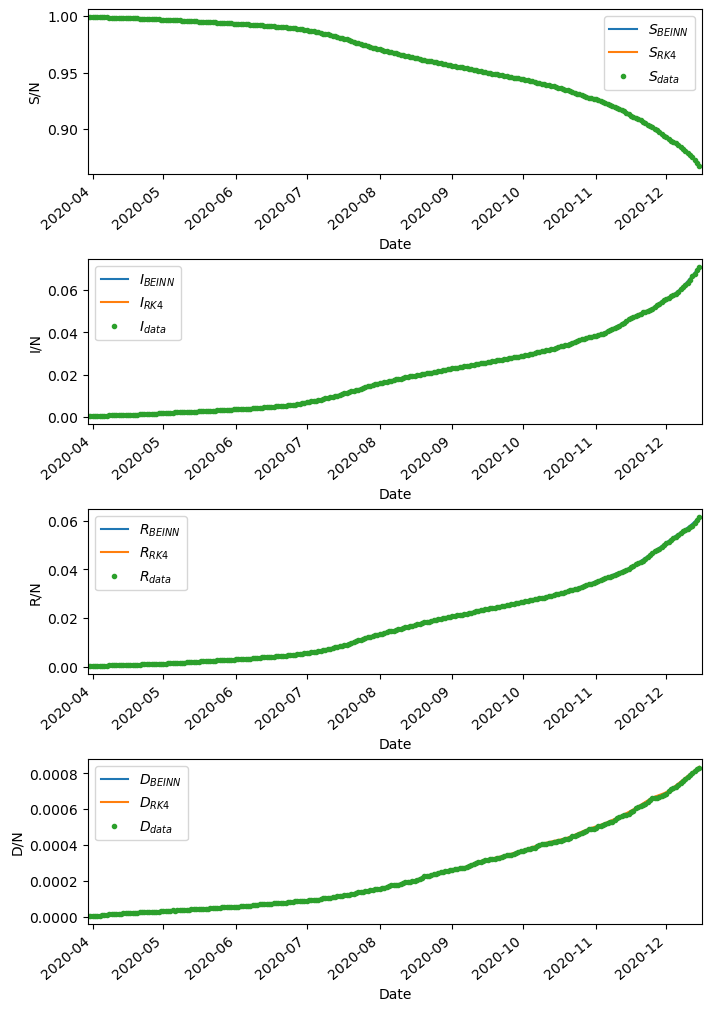

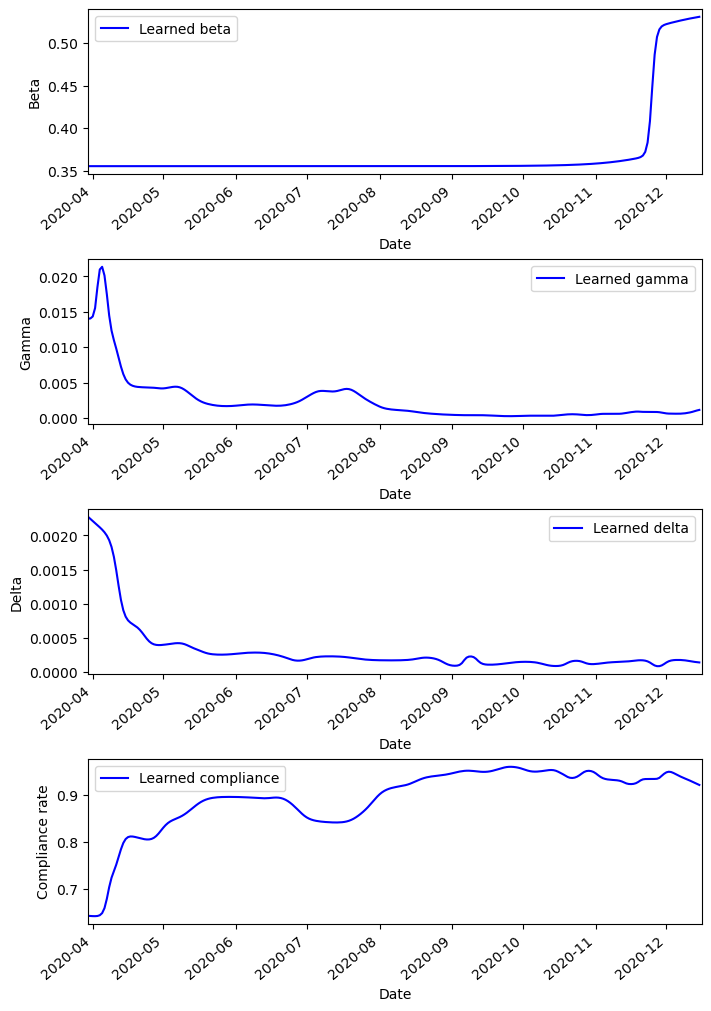

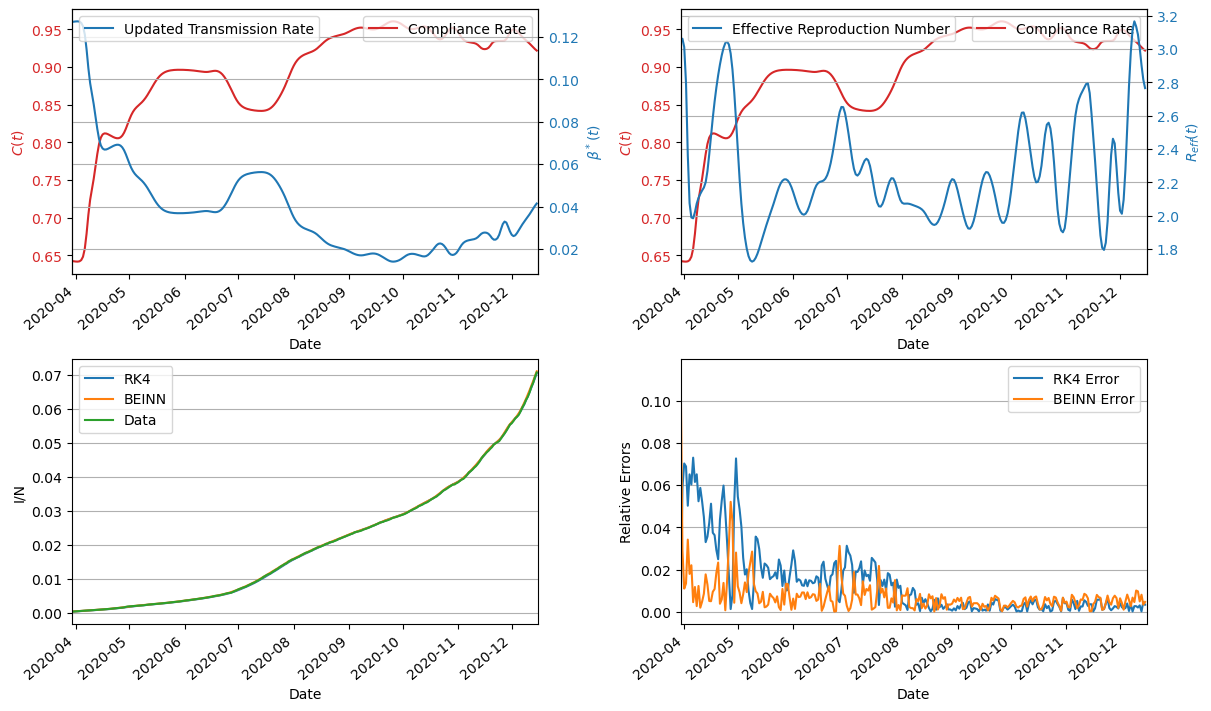

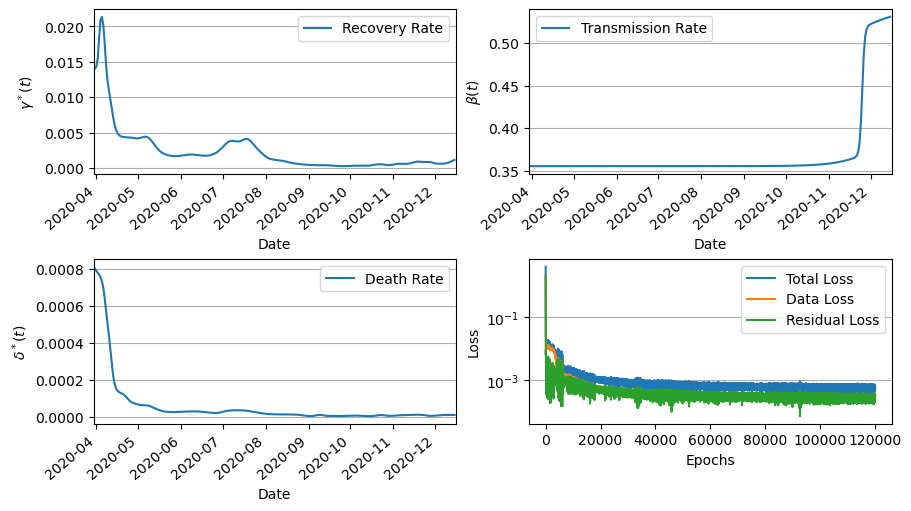

In [7]:
#case 1: 
st ='2020-03-30'
ed ='2020-12-16'
#case 2: 
# st ='2020-12-17'
# ed ='2021-05-16'


#change the from c1 to c2
case ='c1'
date_begin = dt.date(2020, 3, 30) #change from 2020, 12, 17 for Case 2
date_end = date_begin + dt.timedelta(days=261) #change to 150 for case 2
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

rk_err = np.abs(rki - I1)/(I1)
beinn_err = np.abs(I_pred.reshape(-1,1) - I1)/(I1)
fig1, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 10))
y = np.array([S_pred,I_pred,R_pred, D_pred]) ## BEINN
y1 = np.array([S1, I1, R1, D1])
y2 = np.array([rks,rki,rkr, rkd])
y_label = ["S/N","I/N","R/N", "D/N"]
legend = [(r'$S_{BEINN}$',r'$S_{RK4}$',r'$S_{data}$'),(r'$I_{BEINN}$',r'$I_{RK4}$',r'$I_{data}$'),
        (r'$R_{BEINN}$',r'$R_{RK4}$',r'$R_{data}$'), (r'$D_{BEINN}$',r'$D_{RK4}$',r'$D_{data}$')]
for nn, ax in enumerate(axs):
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
    # rotate_labels...
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')
#axs[0].set_title('Comparision')
fig1.savefig(out+"sol_{}.pdf".format(case))
plt.show()

fig2, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 10))
axs[0].plot(dates, beta_pred, label='Learned beta', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Beta')
axs[0].set_xlim(lims)
for label in axs[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[0].legend()

axs[1].plot(dates, gamma_pred*(1.0-compliance_pred), label='Learned gamma', color='blue')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Gamma')
axs[1].set_xlim(lims)
for label in axs[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[1].legend()

axs[2].plot(dates, delta_pred, label='Learned delta', color='blue')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Delta')
axs[2].set_xlim(lims)
for label in axs[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[2].legend()

axs[3].plot(dates, compliance_pred, label='Learned compliance', color='blue')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Compliance rate')
axs[3].set_xlim(lims)
for label in axs[3].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[3].legend()
fig2.savefig(out+"param_{}.pdf".format(case))
plt.show()

fig1b, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(12, 7))
# fig1.suptitle('{}'.format(name), fontsize=16)
color = 'tab:red'
ax1[0, 0].set_xlabel('Date')
ax1[0, 0].set_ylabel(r'$C(t)$', color=color)
ax1[0, 0].plot(dates, compliance_pred, color=color)
ax1[0, 0].tick_params(axis='y', labelcolor=color)
ax1[0, 0].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[0, 0].set_xlim(lims)
for label in ax1[0, 0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0, 0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Transmission Rate'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$C(t)$', color=color)
ax1[0,1].plot(dates, compliance_pred, color=color)
ax1[0,1].tick_params(axis='y', labelcolor=color)
ax1[0,1].legend(['Compliance Rate'], loc='upper right')
ax1[0,1].set_xlim(lims)
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0,1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Effective Reproduction Number'], loc='upper left')
ax2.grid(axis='y')

ax1[1,0].plot(dates, rki, label='RK4')
ax1[1, 0].plot(dates, I_pred, label='BEINN')
ax1[1, 0].plot(dates, I1, label='Data')
ax1[1, 0].set_xlabel('Date')
ax1[1, 0].set_ylabel('I/N')
ax1[1, 0].set_xlim(lims)
for label in ax1[1, 0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1, 0].legend()
ax1[1, 0].grid(axis='y')

ax1[1, 1].plot(dates, rk_err, label='RK4 Error')
ax1[1, 1].plot(dates, beinn_err, label='BEINN Error')
ax1[1, 1].set_xlabel('Date')
ax1[1, 1].set_ylabel('Relative Errors')
ax1[1, 1].set_xlim(lims)
for label in ax1[1, 1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1, 1].legend()
ax1[1, 1].grid(axis='y')
# fig1a.savefig(out+"reff_{}.pdf".format(case))
# fig.savefig("ana1_{}_{}.pdf".format(option, case))
fig1b.savefig(out+"beta_reff_{}.pdf".format(case))
plt.show()




fig1A, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(9, 5))
ax1[0,0].plot(dates, gamma_pred*(1.0-compliance_pred), label='Recovery Rate')
ax1[0,0].set_xlabel('Date')
ax1[0,0].set_ylabel(r'$\gamma^*(t)$')
ax1[0,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,0].legend()
ax1[0,0].grid(axis='y')

ax1[1,0].plot(dates, delta_pred*(1.0-compliance_pred), label='Death Rate')
ax1[1,0].set_xlabel('Date')
ax1[1,0].set_ylabel(r'$\delta^*(t)$')
ax1[1,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,0].legend()
ax1[1,0].grid(axis='y')

ax1[0,1].plot(dates, beta_pred, label='Transmission Rate')
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$\beta(t)$')
ax1[0,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,1].legend()
ax1[0,1].grid(axis='y')


ax1[1,1].semilogy(epochs, total_loss, label='Total Loss')
ax1[1, 1].semilogy(epochs, data_loss, label='Data Loss')
ax1[1, 1].semilogy(epochs, resid_loss, label='Residual Loss')
ax1[1, 1].set_xlabel('Epochs')
ax1[1, 1].set_ylabel('Loss')
# ax1[1].set_xlim(lims)
# for label in ax1[1].get_xticklabels():
#     label.set_rotation(40)
#     label.set_horizontalalignment('right')
ax1[1, 1].legend()
ax1[1, 1].grid(axis='y')
# fig1a.savefig(out+"reff_{}.pdf".format(case))
# fig.savefig("ana1_{}_{}.pdf".format(option, case))
fig1A.savefig(out+"ep_loss_{}.pdf".format(case))
plt.show()





## Epidemiology Parameters

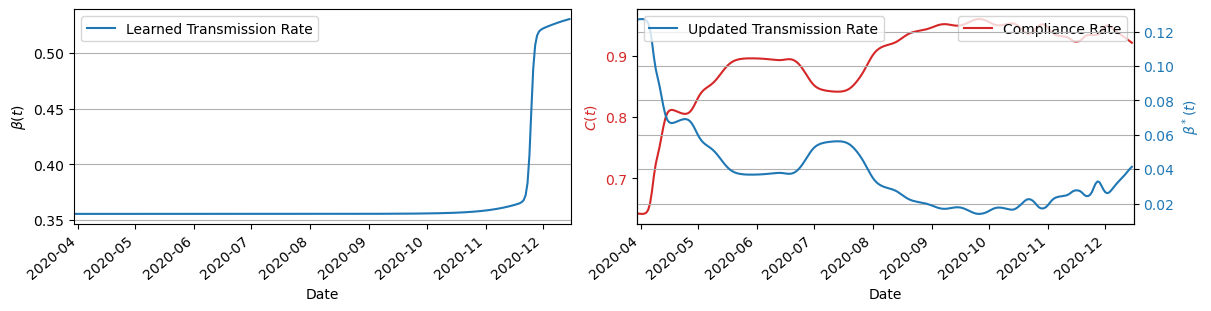

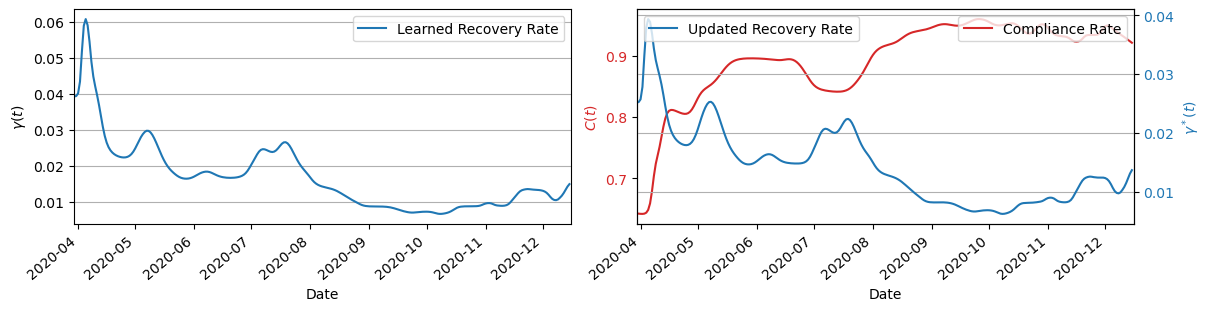

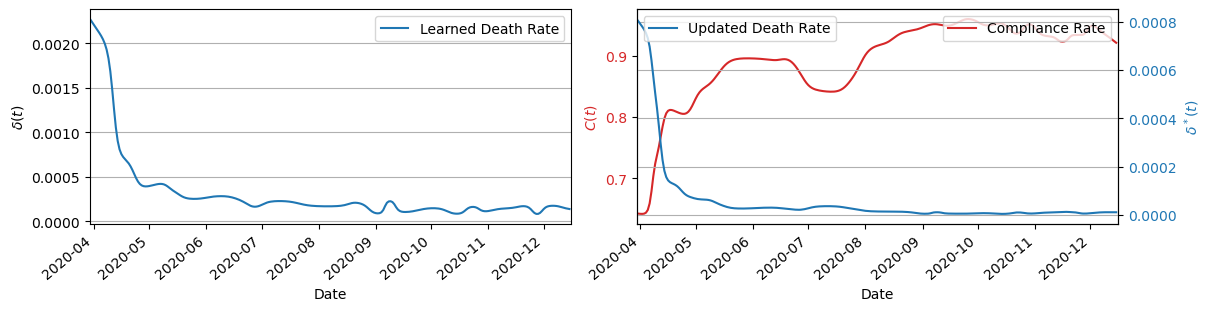

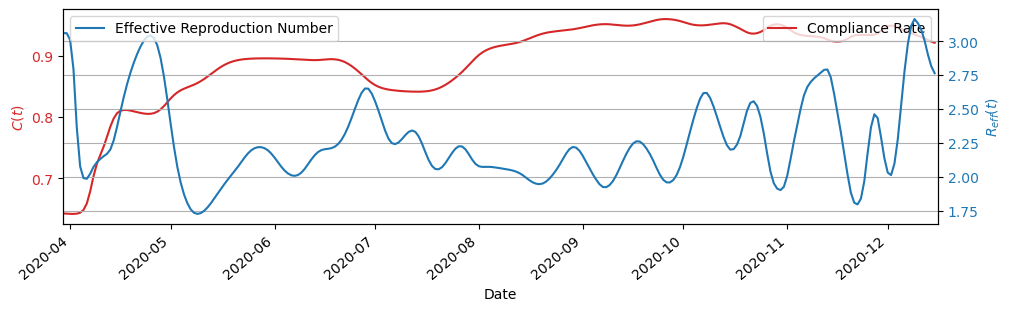

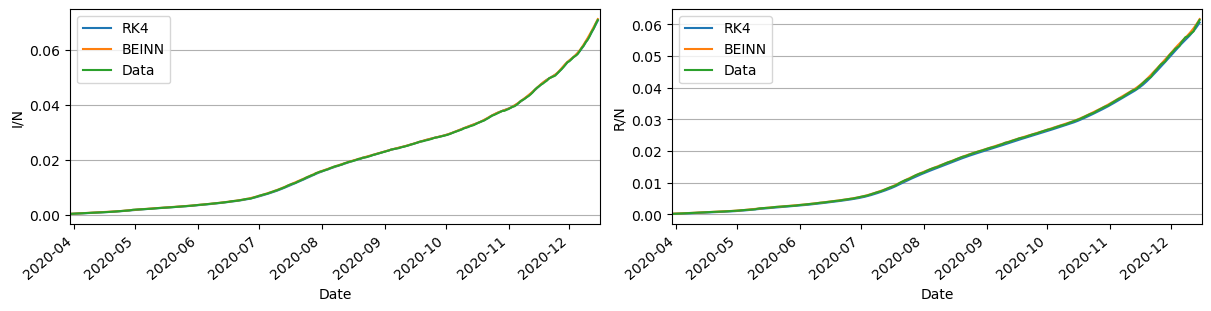

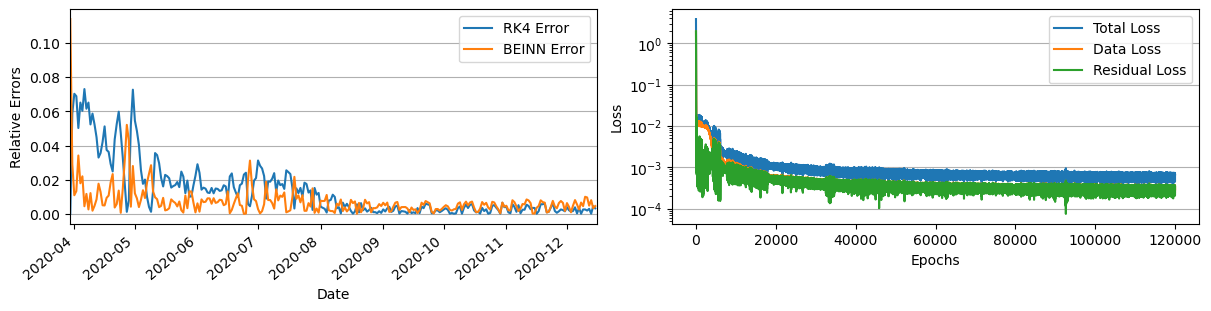

In [8]:
fig1b1, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, beta_pred, label='Learned Transmission Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\beta(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Transmission Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b1.savefig(out+"beta1_{}.pdf".format(case))
plt.show()


fig1b2, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, gamma_pred, label='Learned Recovery Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\gamma(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\gamma^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,gamma_pred*(compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Recovery Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b2.savefig(out+"gamma1_{}.pdf".format(case))
plt.show()



fig1b3, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, delta_pred, label='Learned Death Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\delta(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\delta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,delta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Death Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b3.savefig(out+"delta1_{}.pdf".format(case))
plt.show()


fig1b4, ax1 = plt.subplots(constrained_layout=True,figsize=(10, 3))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(r'$C(t)$', color=color)
ax1.plot(dates, compliance_pred, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Compliance Rate'], loc='upper right')
ax1.set_xlim(lims)
for label in ax1.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Effective Reproduction Number'], loc='upper left')
ax2.grid(axis='y')
fig1b4.savefig(out+"r_eff1_{}.pdf".format(case))
plt.show()

fig1b5, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, rki, label='RK4')
ax1[0].plot(dates, I_pred, label='BEINN')
ax1[0].plot(dates, I1, label='Data')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('I/N')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].plot(dates, rkr, label='RK4')
ax1[1].plot(dates, R_pred, label='BEINN')
ax1[1].plot(dates, R1,  label='Data')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('R/N')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')
fig1b5.savefig(out+"datafit_{}.pdf".format(case))
plt.show()


fig1b6, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, rk_err, label='RK4 Error')
ax1[0].plot(dates, beinn_err, label='BEINN Error')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Relative Errors')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].semilogy(epochs, total_loss, label='Total Loss')
ax1[1].semilogy(epochs, data_loss, label='Data Loss')
ax1[1].semilogy(epochs, resid_loss, label='Residual Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
# ax1[1].set_xlim(lims)
# for label in ax1[1].get_xticklabels():
#     label.set_rotation(40)
#     label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')
fig1b6.savefig(out+"error1_{}.pdf".format(case))
plt.show()

## LSTM and A-LSTM

`LSTM vs A-LSTM comparison for case 1 only`

In [9]:
#get data
inf =I1
com =compliance_pred
tran =beta_pred
reff =beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred)

In [10]:
data_rec =np.hstack((inf, com.reshape(-1,1), tran.reshape(-1,1), reff.reshape(-1,1)))
np.save(out+"data.npy", data_rec)

In [11]:
yp1 =np.loadtxt("Figures/ylstm1.txt") #inf
yp2 =np.loadtxt("Figures/ylstm2.txt") #con
yp3 =np.loadtxt("Figures/ylstm3.txt") #tran
yp4 =np.loadtxt("Figures/ylstm4.txt") #r_eff

yp1a =np.loadtxt("Figures/yalstm1.txt") #inf
yp2a=np.loadtxt("Figures/yalstm2.txt")  #con
yp3a =np.loadtxt("Figures/yalstm3.txt") #con
yp4a =np.loadtxt("Figures/yalstm4.txt") #r_eff


date_begin = dt.date(2020, 3, 30)
date_end = date_begin + dt.timedelta(days=257)
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

fig1A7, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(9, 5))
ax1[0,0].plot(dates, inf[:-4,:], label='Data')
ax1[0,0].plot(dates, yp1, label='LSTM')
ax1[0,0].plot(dates, yp1a, label='A-LSTM')
ax1[0,0].set_xlabel('Date')
ax1[0,0].set_ylabel('I/N')
ax1[0,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,0].legend()
ax1[0,0].grid(axis='y')

ax1[1,0].plot(dates, com[:-4], label='Compliance')
ax1[1,0].plot(dates, yp2, label='LSTM')
ax1[1,0].plot(dates, yp2a, label='A-LSTM')
ax1[1,0].set_xlabel('Date')
ax1[1,0].set_ylabel(r'$c(t)$')
ax1[1,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,0].legend()
ax1[1,0].grid(axis='y')

ax1[0,1].plot(dates, tran[:-4], label='Transmission Rate')
ax1[0,1].plot(dates, yp3, label='LSTM')
ax1[0,1].plot(dates, yp3a, label='A-LSTM')
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$\beta(t)$')
ax1[0,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,1].legend()
ax1[0,1].grid(axis='y')

ax1[1,1].plot(dates, reff[:-4], label='Effective Reproduction Number')
ax1[1,1].plot(dates, yp4, label='LSTM')
ax1[1,1].plot(dates, yp4a, label='A-LSTM')
ax1[1,1].set_xlabel('Date')
ax1[1,1].set_ylabel(r'$R_{eff}(t)$')
ax1[1,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,1].legend()
ax1[1,1].grid(axis='y')

fig1A7.savefig(out+"lstmalst.pdf")
plt.show()


FileNotFoundError: Figures/ylstm1.txt not found.

## Sensitvity Analysis

In [ ]:
layers = ['3', '4', '5']
neurons = ['32', '64']

# Input data
rmse_3 = [2842, 1612, 2268]
rmse_3_64 = [1473, 1592, 1313]

rmse_4 = [1277, 1393, 1128]
rmse_4_64 =[712, 1567,740]

rmse_5 = [726, 1644, 977]
rmse_5_64 = [1482, 1201, 862]

#Input data
mape_3 =[8.66e-3, 1.53e-3, 1.21e-2]
mape_3_64 =[8.55e-3, 7.92e-3, 7.05e-3]

mape_4 =[7.48e-3, 6.86e-3, 6.06e-3]
mape_4_64 =[8.42e-3, 3.83e-3, 4.03e-3]

mape_5 =[8.84e-3, 3.90e-3, 5.25e-3]
mape_5_64 =[6.46e-3, 7.96e-3, 4.33e-3]


# Set bar width
bar_width = 0.2

# Create the figure and axes objects
fig1A8, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[1], rmse_4[1], rmse_5[1]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[1], rmse_4_64[1], rmse_5_64[1]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[0], mape_4[0], mape_5[0]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[0], mape_4_64[0], mape_5_64[0]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A8.savefig(out+'epsilon01.pdf')
plt.show()



# Create the figure and axes objects
fig1A9, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[0], rmse_4[0], rmse_5[0]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[0], rmse_4_64[0], rmse_5_64[0]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[1], mape_4[1], mape_5[1]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[1], mape_4_64[1], mape_5_64[1]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A9.savefig(out+'epsilon02.pdf')
plt.show()



# Create the figure and axes objects
fig1A10, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[2], rmse_4[2], rmse_5[2]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[2], rmse_4_64[2], rmse_5_64[2]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[2], mape_4[2], mape_5[2]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[2], mape_4_64[2], mape_5_64[2]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A10.savefig(out+'epsilon03.pdf')
plt.show()


## Overfitting Analysis

`Analysis for epochs 40000 and 100000`

In [ ]:
loss_train43 =np.loadtxt("Figures/loss_train_40000_1e-07.txt")
loss_val43 =np.loadtxt("Figures/loss_val_40000_1e-07.txt")

loss_train42 =np.loadtxt("Figures/loss_train_40000_0.001.txt")
loss_val42 =np.loadtxt("Figures/loss_val_40000_0.001.txt")

loss_train41 =np.loadtxt("Figures/loss_train_40000_0.1.txt")
loss_val41 =np.loadtxt("Figures/loss_val_40000_0.1.txt")



loss_train_3 =np.loadtxt("Figures/loss_train_100000_1e-07.txt")
loss_val_3 =np.loadtxt("Figures/loss_val_100000_1e-07.txt")

loss_train_2 =np.loadtxt("Figures/loss_train_100000_0.001.txt")
loss_val_2 =np.loadtxt("Figures/loss_val_100000_0.001.txt")

loss_train_1 =np.loadtxt("Figures/loss_train_100000_0.1.txt")
loss_val_1 =np.loadtxt("Figures/loss_val_100000_0.1.txt")

e1 =60000
e2 =100000
e3 =40000
e5 =50000


fig2AA, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train41, label='Train Loss')
ax1[0].semilogx(epochs, loss_val41, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_1, label='Train Loss')
ax1[1].plot(epochs, loss_val_1, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AA.savefig(out+"overfit01.pdf".format())
plt.show()


fig2AB, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train42, label='Train Loss')
ax1[0].semilogx(epochs, loss_val42, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_2, label='Train Loss')
ax1[1].plot(epochs, loss_val_2, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AB.savefig(out+"overfit02.pdf".format())
plt.show()


fig2AC, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train43, label='Train Loss')
ax1[0].semilogx(epochs, loss_val43, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_3, label='Train Loss')
ax1[1].plot(epochs, loss_val_3, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AC.savefig(out+"overfit03.pdf".format())
plt.show()

## Computational Analysis

In [ ]:
epsilon = [r'$\epsilon=1e-1$', r'$\epsilon=1e-2$', r'$\epsilon=1e-3$']
neurons = ['32', '64']

# Input data
rmse_3 = [2842, 1612, 2268]
rmse_3_64 = [1473, 1592, 1313]

rmse_4 = [1277, 1393, 1128]
rmse_4_64 =[712, 1567,740]

rmse_5 = [726, 1644, 977]
rmse_5_64 = [1482, 1201, 862]

#Input data
mape_3 =[8.66e-3, 1.53e-3, 1.21e-2]
mape_3_64 =[8.55e-3, 7.92e-3, 7.05e-3]

mape_4 =[7.48e-3, 6.86e-3, 6.06e-3]
mape_4_64 =[8.42e-3, 3.83e-3, 4.03e-3]

mape_5 =[8.84e-3, 3.90e-3, 5.25e-3]
mape_5_64 =[6.46e-3, 7.96e-3, 4.33e-3]


# Set bar width
bar_width = 0.2



# Create the figure and axes objects
fig1ABB, ax1 = plt.subplots(constrained_layout=True,figsize=(5, 4))
# Set the x-axis tick locations and labels
ax1.set_xticks(np.arange(len(epsilon)))
ax1.set_xticklabels(epsilon)
# Set the y-axis label
ax1.set_ylabel('CPU Time (Seconds)')
ax1.set_xlabel('Epilson')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1.bar(np.arange(len(epsilon)), [419117, 413836, 424608], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1.bar(np.arange(len(epsilon)) + bar_width, [711102, 714602, 728276], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1.legend()
fig1ABB.savefig(out+'eps_cputime.pdf')
plt.show()


